In [22]:
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

image_dir = "./images"
label_dir = "./labels"

images = glob(os.path.join(image_dir, '*.png'))
labels = glob(os.path.join(label_dir, '*.png'))

In [23]:
tags = {0:None, 1:"Buildings", 2:"Fences",3:"Other",4:"Pedestrians",5:"Poles",
         6:"RoadLines",7:"Roads",8:"Sidewalks",9:"Vegetation",10:"Vehicles",11:"Walls",12:"TrafficSigns"}
total_images = len(images)
total_labels = len(labels)
print("Total images:", total_images)
print("Total labels:", total_labels)

Total images: 1000
Total labels: 1000


In [35]:
# creating data object
d = {'images':images, 'labels':labels}
columns = ['images', 'labels']
data = pd.DataFrame(d, columns=columns)

In [3]:
def crop(img):
    img_copy = np.copy(img)
    #img_copy = cv2.resize(img_copy, (400,300))
    img_copy = img_copy[100:500,:]
    return img_copy

In [4]:
idx = np.random.randint(total_images)
image = cv2.imread(images[idx])
label = cv2.imread(labels[idx])[:,:,2]

image = crop(image)
label = crop(label)

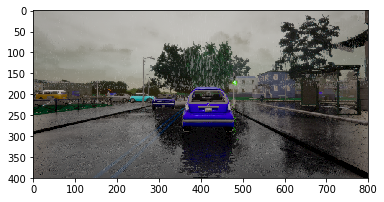

In [5]:
plt.imshow(image)

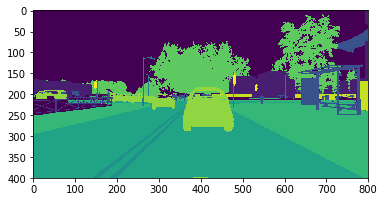

In [6]:
plt.imshow(label)

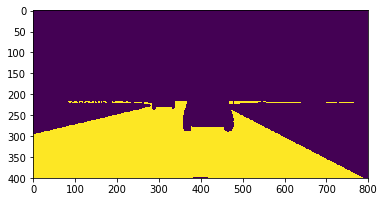

In [7]:
label[label == 6] = 7
lb_road = np.zeros_like(label)
lb_road[label == 7] = 1
plt.imshow(lb_road)

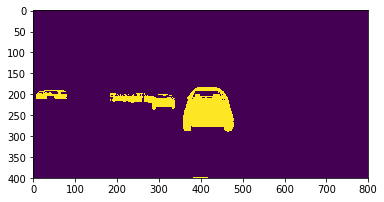

In [8]:
lb_car = np.zeros_like(label)
lb_car[label == 10] = 1
plt.imshow(lb_car)

In [14]:
lb_car

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [18]:
final_label = np.array([lb_road, lb_car])

In [19]:
final_label.shape

(2, 400, 800)

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from keras import initializers
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Lambda, Conv2D, MaxPooling2D, Cropping2D, Dropout, BatchNormalization, Conv2DTranspose

# split training and validation data
train_samples, validation_data = train_test_split(data, test_size=0.4)
validation_samples, test_samples = train_test_split(validation_data, test_size=0.5)

# define the generator
def generator(samples, batch_size = 32):
    num_samples = len(samples)
    corr_coeff = 0.6        # the coefficient for left and right camera images
    while 1:
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for ind, sample in batch_samples.iterrows():
                # center image
                center_image = cv2.imread(sample['center_img'])
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                angle = sample['steering_angle']
                images.append(center_image)
                angles.append(angle)
                
                # left image
                left_image = cv2.imread(sample['left_img'])
                left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
                left_angle = sample['steering_angle'] + corr_coeff#* (1 - corr_coeff)
                images.append(left_image)
                angles.append(left_angle)
                
                # right image
                right_image = cv2.imread(sample['right_img'])
                right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
                right_angle = sample['steering_angle'] - corr_coeff#* (1 + corr_coeff)
                images.append(right_image)
                angles.append(right_angle)
                
                # flipped images
                # flipped center - not needed since there are left and right flipped images.
                flipped_center_image = cv2.flip(center_image, 1)
                flipped_angle = -angle
                #images.append(flipped_center_image)
                #angles.append(flipped_angle)
                
                # flipped left
                flipped_left_image = cv2.flip(left_image, 1)
                flipped_left_angle = -left_angle
                images.append(flipped_left_image)
                angles.append(flipped_left_angle)
                
                # flipped right
                flipped_right_image = cv2.flip(right_image, 1)
                flipped_right_angle = -right_angle
                images.append(flipped_right_image)
                angles.append(flipped_right_angle)
                
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

# define batch size and create the generators
batch_size = 128
train_generator = generator(train_samples, batch_size)
validation_generator = generator(validation_samples, batch_size)
droprate = 0.25
# define the model
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (160, 320, 3)))
model.add(Cropping2D(cropping = ((70, 25), (0, 0))))
model.add(Conv2D(16, (5, 5), kernel_initializer=initializers.TruncatedNormal(), activation = "relu"))
#model.add(BatchNormalization())
model.add(MaxPooling2D())
#model.add(Dropout(droprate))
model.add(Conv2D(32, (3, 3), kernel_initializer=initializers.TruncatedNormal(), activation = "relu"))
#model.add(BatchNormalization())
model.add(MaxPooling2D())
#model.add(Dropout(droprate))
model.add(Conv2D(64, (3, 3), kernel_initializer=initializers.TruncatedNormal(), activation = "relu"))
#model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2DTranspose(1, (14,14)))

model.summary()